In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import seaborn as sns

import scikitplot as skplt

import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def distribucion(attr,datos):
    plt.figure()
    sns.distplot(datos[attr])
    
def relevancia(clase,attr,datos):
    plt.figure()
    gs = datos.groupby(clase)
    for x in datos[clase].unique():
        plt.legend()
        sns.distplot(gs.get_group(x)[attr], label=x)
        
def cuenta(attr,datos):
    plt.figure()
    sns.countplot(y=attr,data=datos)
    
def muestra_relevancias(nombres, relevancias):
    '''Función para mostrar una gráfica con el grado de relevancia de cada atributo
    
    Recibe:
       - nombres: nombres de todos los atributos
       - relevancias: de cada atributo, calculadas mediante alguna técnica
    '''
    plt.figure(figsize=(len(nombres)/4,5))
    serie = pd.Series(relevancias, index=nombres)
    serie.plot(kind='bar')
    
def muestra_seleccion(nombres, mascara):
    '''Función para mostrar los nombres de los atributos seleccionados a partir de una máscara de booleanos
    
    Recibe:
       - nombres: nombres de todos los atributos
       - mascara: lista de booleanos que determina si un atributo se selecciona, o no
    '''    
    seleccionados = [n for n,m in zip(nombres, mascara) if m]
    print(len(seleccionados), seleccionados)
    

def muestra_evolucion_un_parametro(grid, parametro):
    ''' Muestra la evolución de los resultados de gridsearch en función de un parámetro 
    '''
    # Volcamos los resultados en un dataframe y seleccionamos la columna del parámetro a visualizar
    valores_params = pd.DataFrame(list(grid.cv_results_['params']))[parametro]
    
    # Creamos una serie con los resultados y usando como índice los valores del parámetro
    resultados = pd.Series(grid.cv_results_['mean_test_score'], index=valores_params)
    resultados.plot()
    

def muestra_evolucion_dos_parametros(grid, parametros):
    ''' Muestra la evolución de los resultados de gridsearch en función de un parámetro 
    '''
    # Volcamos los resultados en un dataframe y seleccionamos las columnas de los parámetros a visualizar
    valores_params = pd.DataFrame(list(grid.cv_results_['params']))[parametros]
    
    # Creamos un DataFrame con tres columnas: los resultados y los valores de los dos paráemtros
    resultados = pd.DataFrame(list(grid.cv_results_['mean_test_score']), columns=['resultados'])
    resultados = pd.concat([resultados, valores_params], axis=1)
    
    # Creamos una tabla pivot a partir de losn resultados y la visualizamos
    tabla = resultados.pivot_table(index=parametros[0], columns=parametros[1], values='resultados', fill_value=0)
    sns.heatmap(tabla, annot=True, fmt='.4f', cmap='Greens')
    plt.show()

In [3]:
m_cols = ['id', 'year', 'title']
movies = pd.read_csv("data/movie_titles.csv",sep=',', names=m_cols, encoding='latin-1').set_index('id')

In [4]:
movies.head()

,year,title
id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [5]:
df1 = pd.read_csv('data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df2 = pd.read_csv('data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

In [8]:
df = df1
df.head()


,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


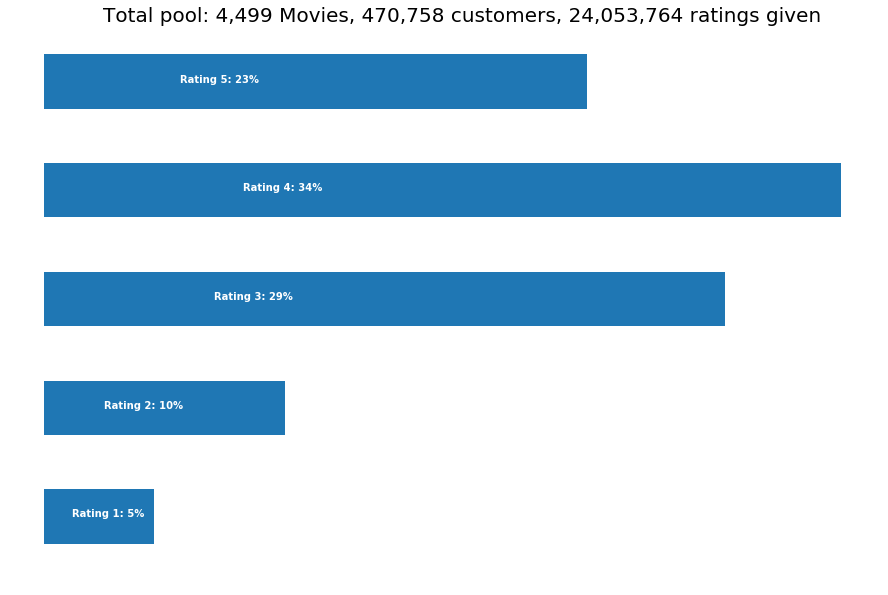

In [9]:
p = df.groupby('Rating')['Rating'].agg(['count'])
movie_count = df.isnull().sum()[1]
cust_count = df['Cust_Id'].nunique() - movie_count
rating_count = df['Cust_Id'].count() - movie_count
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [11]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [12]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
